In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 1. 加载图像
# img1 = cv2.imread('../source/template_temp/3.jpg')  # 查询图像
img1 = cv2.imread('../source/template3.jpg')  # 查询图像
img2 = cv2.imread('../source/1.1/tv201712281243203UDNG6.jpg')  # 训练图像


[ WARN:0@0.575] global loadsave.cpp:241 findDecoder imread_('../source/1.2/tv201712281243203UDNG6.jpg'): can't open/read file: check file path/integrity


In [4]:
def SIFT4H(img1, img2):

    # 初始化SIFT检测器
    sift = cv2.SIFT_create()
    # sift = cv2.SIFT_create(nfeatures=1000, contrastThreshold=0.04, edgeThreshold=10)

    # 使用SIFT找到关键点和描述符
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN 参数设计
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)   # 或传递一个空字典

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # 准备计算单应性矩阵的数据
    good_matches = []
    pts1 = []
    pts2 = []

    # 应用比例测试，如FlannBasedMatcher文档中所述
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    pts1 = np.float32(pts1).reshape(-1, 2)
    pts2 = np.float32(pts2).reshape(-1, 2)

    # 获取单应性矩阵
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

    # 绘制匹配结果
    draw_params = dict(matchColor=(0, 255, 0),  # 使用绿色绘制匹配项
                       singlePointColor=None,
                       matchesMask=mask.ravel().tolist(),  # 只绘制内部点
                       flags=2)


    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, **draw_params)

    print(len(good_matches))
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title('Matches')
    plt.show()

    return H

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def SIFT4HBF(img1, img2):
    # 初始化SIFT检测器
    sift = cv2.SIFT_create()

    # 使用SIFT找到关键点和描述符
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # 创建BFMatcher对象，使用默认参数
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)  # k=2以获取两个最佳匹配

    # 应用比例测试，如 Lowe's ratio test 所述
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # 准备计算单应性矩阵的数据
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

    # 获取单应性矩阵
    if len(good_matches) > 3:  # 需要至少4个点来计算单应性矩阵
        H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)
    else:
        print("Not enough matches are found - %d/%d" % (len(good_matches), 4))
        H = None
        mask = None

    # 绘制匹配结果
    draw_params = dict(matchColor=(0, 255, 0),  # 使用绿色绘制匹配项
                       singlePointColor=None,
                       matchesMask=mask.ravel().tolist() if mask is not None else None,  # 只绘制内部点
                       flags=2)

    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, **draw_params)

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title('Good Matches')
    plt.show()

    print(len(good_matches))
    return H

In [6]:
# 调用函数
H_SIFT = SIFT4HBF(img1, img2)

error: OpenCV(4.10.0) /io/opencv/modules/features2d/src/sift.dispatch.cpp:512: error: (-5:Bad argument) image is empty or has incorrect depth (!=CV_8U) in function 'detectAndCompute'


In [309]:
def transform_points_and_display(img2, points, H):

    # 将点转换为浮点数并增加一个维度以适应perspectiveTransform的要求
    points = np.array(points).reshape(-1, 1, 2).astype(np.float32)

    # 使用单应性矩阵H对点进行变换
    transformed_points = cv2.perspectiveTransform(points, H)

    # img_copy = img1.copy()
    # for t_point in points:
    #     cv2.circle(img_copy, tuple(map(int, t_point)), 5, (0, 255, 0), -1)  # 变换后的点用蓝色绘制
    #
    # # 显示结果图像
    # plt.figure(figsize=(10, 8))
    # plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    # plt.title('Transformed Points on Image')
    # plt.show()

    img_copy = img2.copy()
    for t_point in transformed_points.reshape(-1, 2):
        cv2.circle(img_copy, tuple(map(int, t_point)), 5, (255, 0, 0), -1)  # 变换后的点用蓝色绘制

    # 显示结果图像
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.title('Transformed Points on Image')
    plt.show()

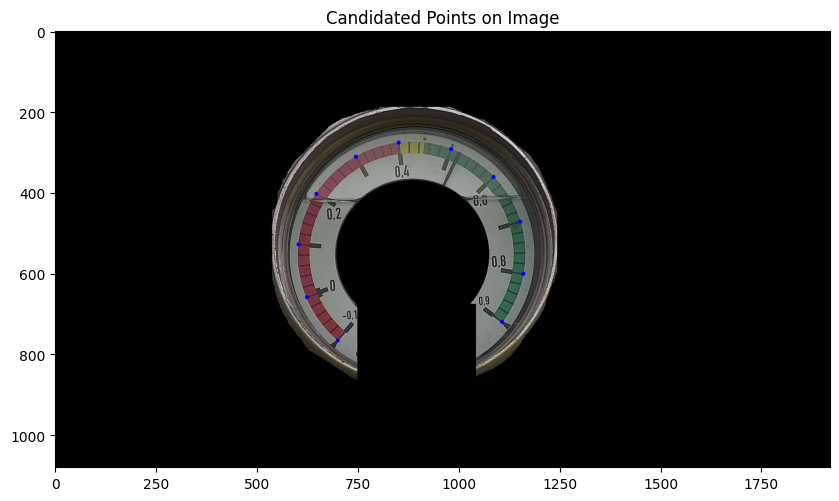

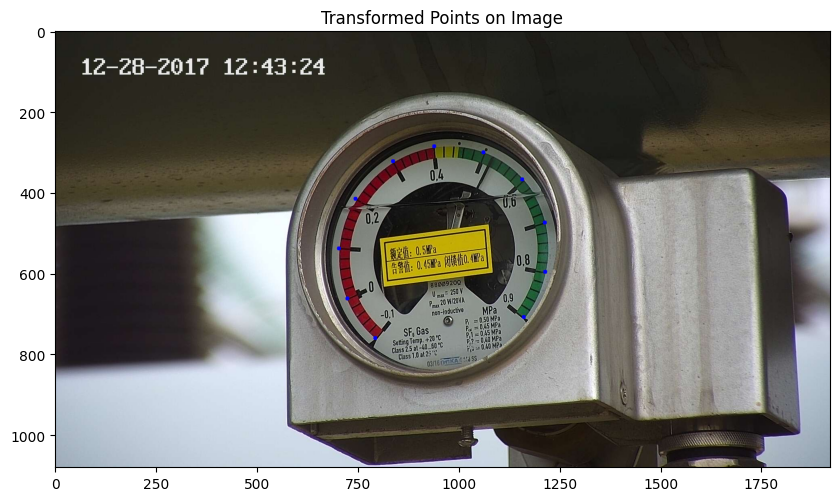

In [310]:
candidate_point = np.array([
    (700,766),
    (624,659), (603,528), (647,403), (745,311), (851,276),
    (981,292), (1086,361), (1152,472), (1160,601),
    (1107,720)
], dtype=float)

img_copy = img1.copy()
for t_point in candidate_point:
    cv2.circle(img_copy, tuple(map(int, t_point)), 5, (255, 0, 0), -1)  # 变换后的点用蓝色绘制
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
plt.title('Candidated Points on Image')
plt.show()

transform_points_and_display(img2, candidate_point, H_SIFT)